In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
from os.path import isfile
import pandas as pd
from sanitizer import sanitize_and_save
import seaborn as sns
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import train_test_split

In [3]:
plt.style.use("ggplot")
c_lst = plt.rcParams["axes.prop_cycle"].by_key()["color"]
c_lst.append(c_lst.pop(0))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", c_lst)
if not isfile("../data/refined.parquet"):
    print("Local refined copy missing.")
    print("Proceed to load and process raw backup...")
    sanitize_and_save()
    print("Refined restoration complete.")
df = pd.read_parquet("../data/refined.parquet")

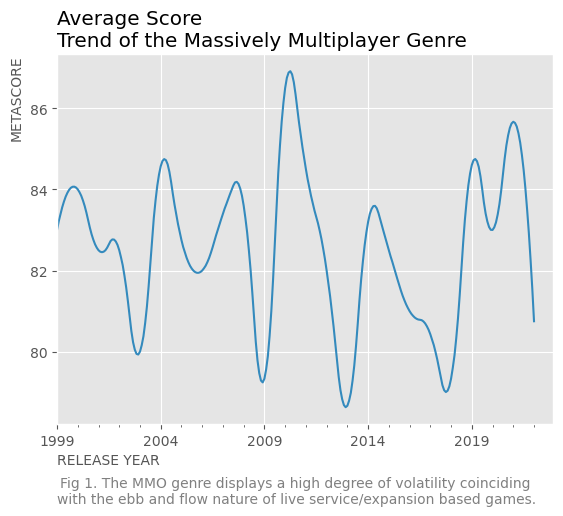

In [686]:
# See df.generes.columns to choose which genres are to be displayed.
focus = ["Massively Multiplayer"]
for genre in focus:
    g = df.general.groupby(df.genres[genre], group_keys=True).get_group(True)
    # Adjust to_period offset string if you wish to analyze different
    # timeframes, make sure resample is always a smaller or equivalent
    # frequency if so.
    g = g.metascore.groupby(df.general.release_date.dt.to_period("Y")).mean()
    g = g.resample("M").asfreq()
    g.index = g.index.to_timestamp()
    g = g.interpolate("polynomial", order=2)  # order=1 to disable smoothing.
    g.plot.line()
#plt.legend(focus)  # Enable if multiple are to be graphed on same plot.
plt.xlabel("RELEASE YEAR", loc="left", fontsize=10)
plt.ylabel("METASCORE", loc="top", fontsize=10)
plt.title(f"Average Score \nTrend of the {focus[0]} Genre", loc="left")
cap="""
    Fig 1. The MMO genre displays a high degree of volatility coinciding 
    with the ebb and flow nature of live service/expansion based games.
    """
plt.figtext(0.5, -.05, cap, wrap=True, ha="center", fontsize=10, color="grey")
#plt.savefig("../analysis_results/figures/fig1.png", bbox_inches="tight")
plt.show()

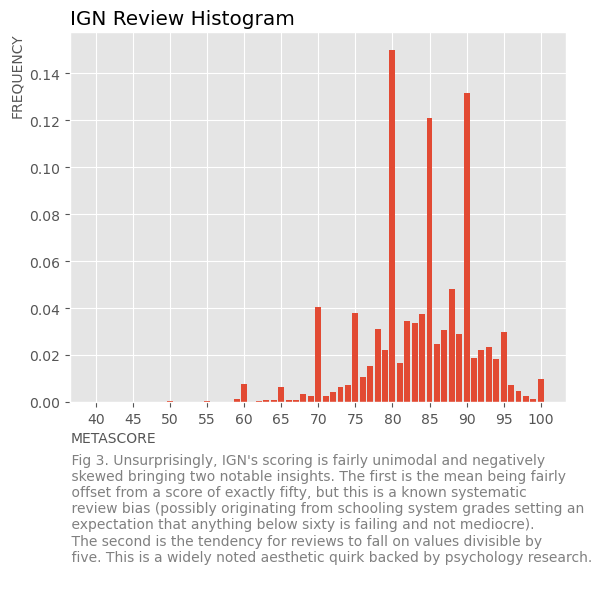

In [263]:
ign = df.critics["IGN"]
counts = ign[ign>=0].value_counts(normalize=True).sort_index()
plt.bar(counts.index, counts, color="C6")
plt.locator_params(axis='x', nbins=20)
plt.xlabel("METASCORE", loc="left", fontsize=10)
plt.ylabel("FREQUENCY", loc="top", fontsize=10)
plt.title("IGN Review Histogram", loc="left")
cap="""
    Fig 3. Unsurprisingly, IGN's scoring is fairly unimodal and negatively
    skewed bringing two notable insights. The first is the mean being fairly 
    offset from a score of exactly fifty, but this is a known systematic 
    review bias (possibly originating from schooling system grades setting an
    expectation that anything below sixty is failing and not mediocre).
    The second is the tendency for reviews to fall on values divisible by 
    five. This is a widely noted aesthetic quirk backed by psychology research.
    """
plt.figtext(0.1, -.25, cap, wrap=True, ha="left", fontsize=10, color="grey")
#plt.savefig("../analysis_results/figures/fig3.png", bbox_inches="tight")
plt.show()

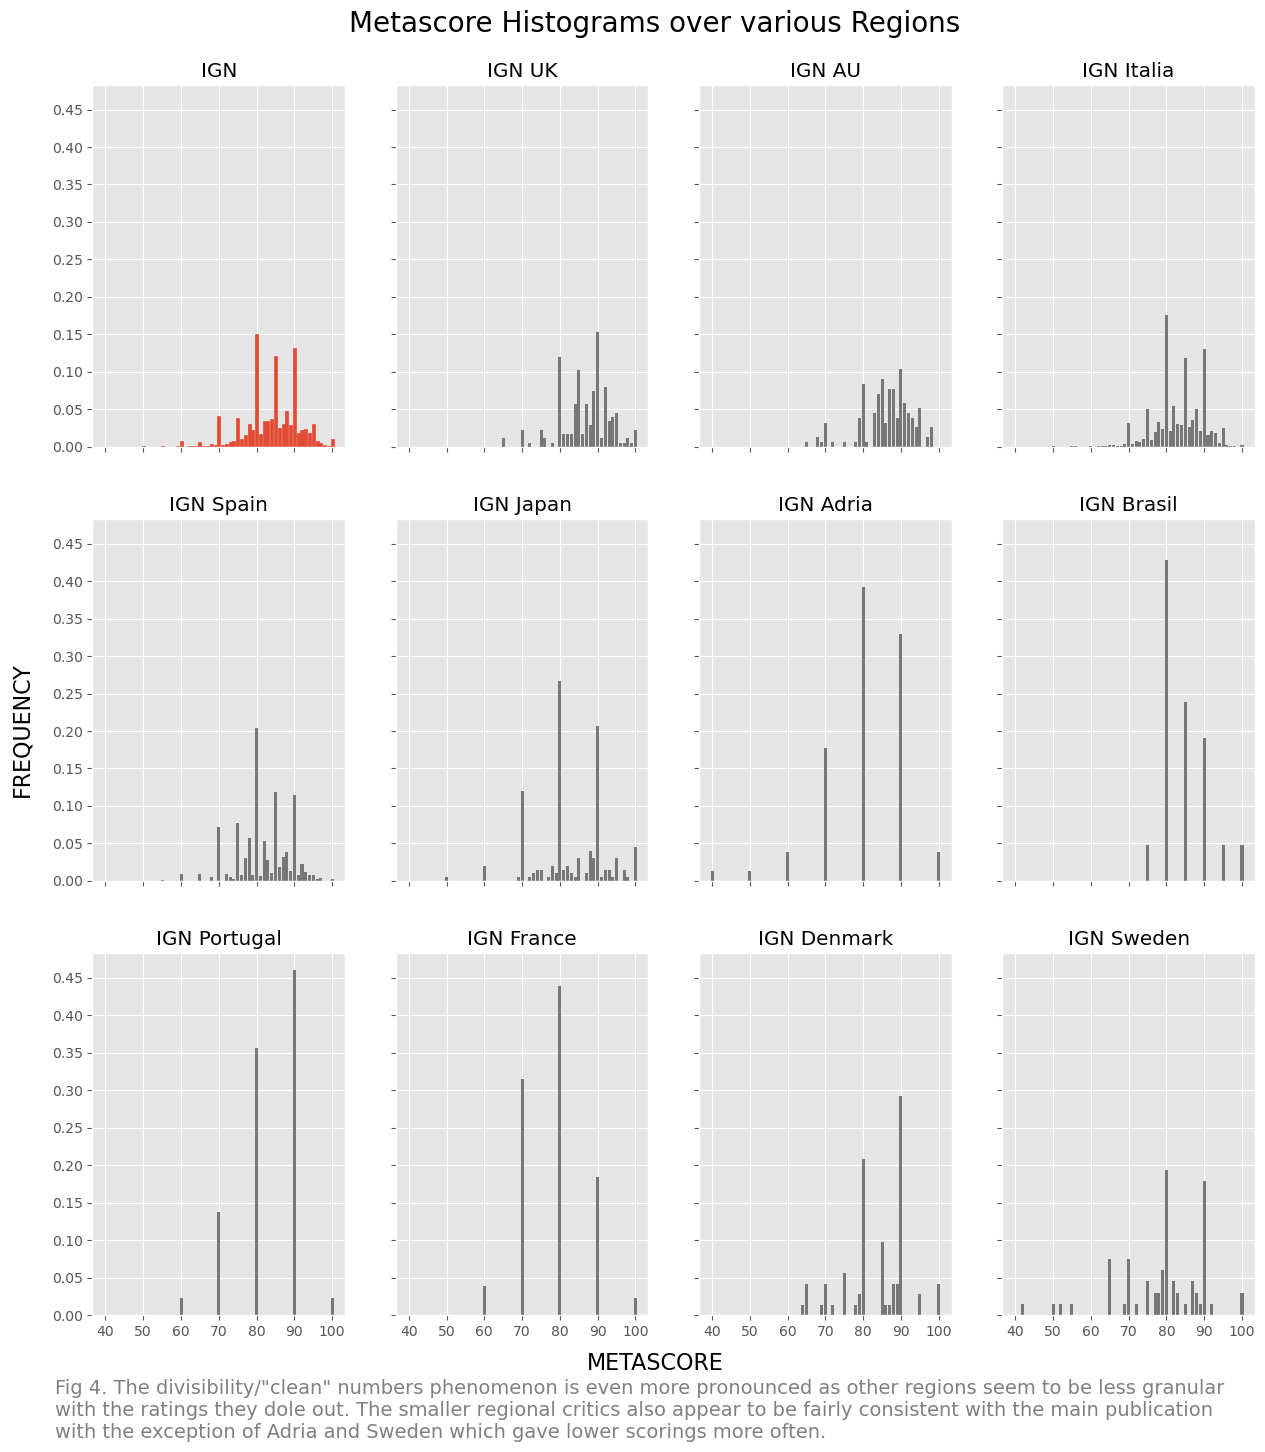

In [41]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(15, 15),
)
for i, col in enumerate(df.critics.filter(like="IGN").columns):
    regional = df.critics[col]
    counts = regional[regional >= 0].value_counts(normalize=True).sort_index()
    ax = axes[i // 4, i % 4]
    bars = ax.bar(counts.index, counts, color="C2")
    if i == 0:
        [bar.set_color("C6") for bar in bars]
    ax.set_title(col)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
fig.supxlabel("METASCORE", x=.5, y=0.07, fontsize=16)
fig.supylabel("FREQUENCY", x=0.07, y=0.5, fontsize=16)
fig.suptitle("Metascore Histograms over various Regions", fontsize=20)
plt.subplots_adjust(top=0.93)
cap=(
    "Fig 4. The divisibility/\"clean\" numbers phenomenon is even more "
    "pronounced as other regions seem to be less granular \nwith the ratings "
    "they dole out. The smaller regional critics also appear to be fairly "
    "consistent with the main publication \nwith the exception of Adria "
    "and Sweden which gave lower scorings more often. "
    )
plt.figtext(0.1, .03, cap, wrap=True, ha="left", fontsize=14, color="grey")
#plt.savefig("../analysis_results/figures/fig4.png", bbox_inches="tight")
plt.show()

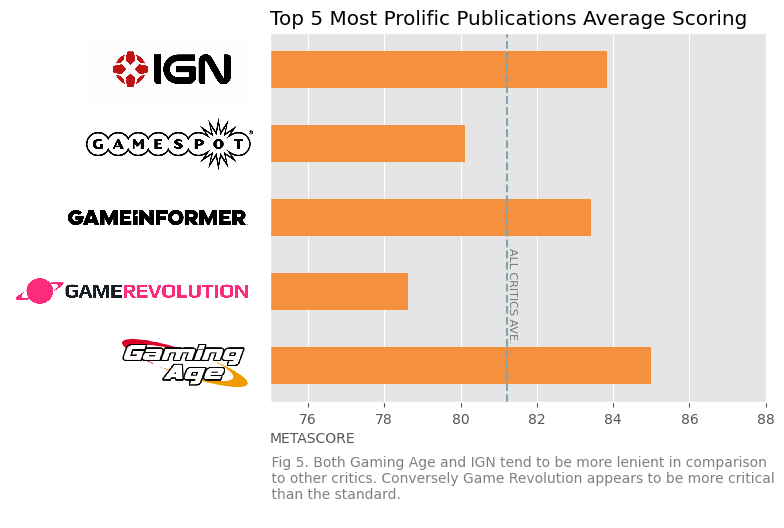

In [76]:
count = df.critics[df.critics != -1].count()
prolific = count.sort_values().tail(5)
top5df = df.critics[prolific.index]
bars = top5df[top5df != -1].mean().plot.barh(color="#F4903E")
ax = plt.gca()
tick_labels = ax.xaxis.get_ticklabels()
img = [
    plt.imread("../analysis_results/resources/gamingage.png"),
    plt.imread("../analysis_results/resources/gamerevolution.png"),
    plt.imread("../analysis_results/resources/gameinformer.png"),
    plt.imread("../analysis_results/resources/gamespot.png"),
    plt.imread("../analysis_results/resources/ign.png")
]
zoom = [.08, .065, .15, .2, .13]
for i, im in enumerate(img):
    ib = OffsetImage(im, zoom=zoom[i])
    ib.image.axes = ax
    ab = AnnotationBbox(ib,
        (75, i),
        frameon=False,
        box_alignment=(1.1, .5)
    )
    ax.add_artist(ab)
plt.xlim(75, 88)
ax.get_yaxis().set_visible(False)
mean = df.general.metascore.mean()
plt.axvline(mean, c="#7DA5B5", ls="--")
ant = "ALL CRITICS AVE."
plt.text(mean, .33, ant, rotation=-90, c="C2", fontsize=8)
plt.xlabel("METASCORE", loc="left", fontsize=10)
plt.title("Top 5 Most Prolific Publications Average Scoring", loc="left")
cap="""
    Fig 5. Both Gaming Age and IGN tend to be more lenient in comparison
    to other critics. Conversely Game Revolution appears to be more critical
    than the standard.
    """
plt.figtext(0.1, -.12, cap, wrap=True, ha="left", fontsize=10, color="grey")
#plt.savefig("../analysis_results/figures/fig5.png", bbox_inches="tight")
plt.show()

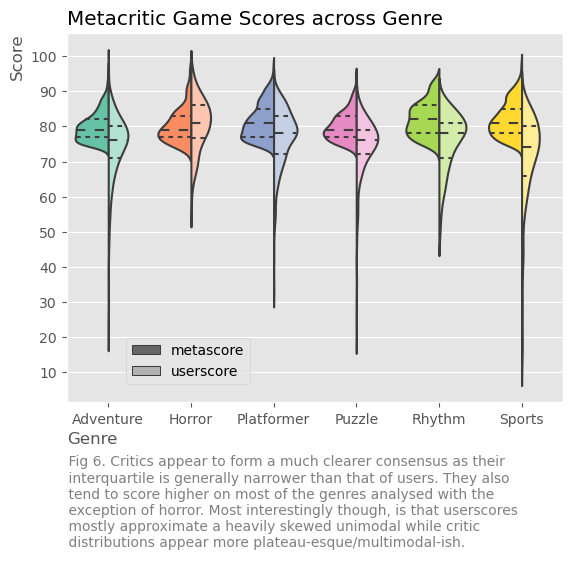

In [144]:
focus = ["Adventure", "Horror", "Platformer", "Puzzle", "Rhythm", "Sports"]
df_lst = []
for genre in focus:
    g = (
        df
        .general[["metascore", "userscore"]]
        .groupby(df.genres[genre], group_keys=True)
        .get_group(True)
    )
    g["userscore"] = 10 * g["userscore"]
    g = g.melt()
    g["genre"] = genre
    df_lst.append(g)
full = pd.concat(df_lst)
ax = sns.violinplot(
    full,
    x="genre",
    y="value",
    hue="variable",
    split=True,
    inner="quart",
    palette=[".4", ".7"]
)
colors = sns.color_palette("Set2")
for ind, violin in enumerate(ax.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc=(.12, .05))
plt.locator_params(axis='y', nbins=20)
plt.xlabel("Genre", loc="left")
plt.ylabel("Score", loc="top")
plt.title("Metacritic Game Scores across Genre", loc="left")
cap="""
    Fig 6. Critics appear to form a much clearer consensus as their
    interquartile is generally narrower than that of users. They also
    tend to score higher on most of the genres analysed with the
    exception of horror. Most interestingly though, is that userscores
    mostly approximate a heavily skewed unimodal while critic 
    distributions appear more plateau-esque/multimodal-ish.
    """
plt.figtext(0.1, -.22, cap, wrap=True, ha="left", fontsize=10, color="grey")
#plt.savefig("../analysis_results/figures/fig6.png", bbox_inches="tight")
plt.show()

In [6]:
TO_ANALYZE = "GameSpot"
score = df.critics[TO_ANALYZE]
reviewed = score[score >= 0]
rdf = df[["general", "genres"]].query("index in @reviewed.index")
features = pd.concat([pd.get_dummies(rdf.general.platform, dtype="bool"), rdf.genres], axis=1)
train_x, test_x, train_y, test_y = (
    train_test_split(
        features,
        reviewed,
        test_size=0.3,
        random_state=0,
    )
)

In [9]:
model = LogReg(max_iter=200).fit(train_x, train_y)
print(f"Logistic Accuracy: {model.score(test_x, test_y)}")

Logistic Accuracy: 0.22884615384615384


Epoch 1/20
114/114 [==============================] - 1s 3ms/step - loss: 1714.1760
Epoch 2/20
114/114 [==============================] - 0s 3ms/step - loss: 110.9070
Epoch 3/20
114/114 [==============================] - 0s 2ms/step - loss: 80.6473
Epoch 4/20
114/114 [==============================] - 0s 2ms/step - loss: 67.0019
Epoch 5/20
114/114 [==============================] - 0s 3ms/step - loss: 61.5979
Epoch 6/20
114/114 [==============================] - 0s 3ms/step - loss: 59.0426
Epoch 7/20
114/114 [==============================] - 0s 2ms/step - loss: 58.4121
Epoch 8/20
114/114 [==============================] - 0s 2ms/step - loss: 57.5900
Epoch 9/20
114/114 [==============================] - 0s 2ms/step - loss: 56.1451
Epoch 10/20
114/114 [==============================] - 0s 2ms/step - loss: 54.6215
Epoch 11/20
114/114 [==============================] - 0s 2ms/step - loss: 55.4792
Epoch 12/20
114/114 [==============================] - 0s 2ms/step - loss: 53.7401
Epoch 13/2

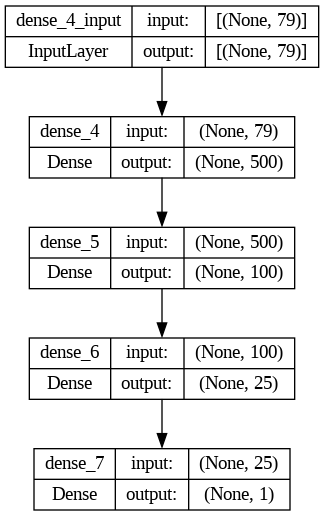

In [8]:
EPOCH=20
model = Sequential()
model.add(Dense(500, "relu", input_dim=train_x.shape[1]))
model.add(Dense(100, "relu"))
model.add(Dense(25, "relu"))
model.add(Dense(1))
model.compile(
        loss="mean_squared_error", 
        optimizer="adam",
)
model.fit(train_x, train_y, epochs=EPOCH)
model.evaluate(test_x, test_y)
plot_model(
    model,
    to_file='../analysis_results/figures/neural_net_model.png',
    show_shapes=True,
    show_layer_names=True
)
#model.summary()

In [335]:
GAME_IDX = 15
print(df[df.index == test_x.iloc[GAME_IDX].name].general.title)
predicted = model.predict(test_x.iloc[GAME_IDX].to_frame().T)[0][0]
actual = test_y.iloc[GAME_IDX]
print(f"\nPredicted GameSpot score: {predicted}")
print(f"Actual score given: {actual}")

611    It Takes Two
Name: title, dtype: string
1/1 [==============================] - 0s 16ms/step

Predicted GameSpot score: 89.70545959472656
Actual score given: 90
